# Density based clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("ravdess_quantitative.csv")

First, a normalization is needed.

In [ ]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()
X = scaler.fit_transform(df.values)

It is necessary to embed the dataset in a lower-dimensional space. I choose to use ISOMAP

In [46]:
from sklearn.manifold import Isomap
isomap = Isomap(n_neighbors=20, n_components=2, p=1)
S = isomap.fit_transform(X)
plt.scatter(S[:,0], S[:,1], c=df.vocal_channel)

AttributeError: 'DataFrame' object has no attribute 'vocal_channel'

## DBSCAN

DBSCAN:
	number of custers = 6
	outliers 566


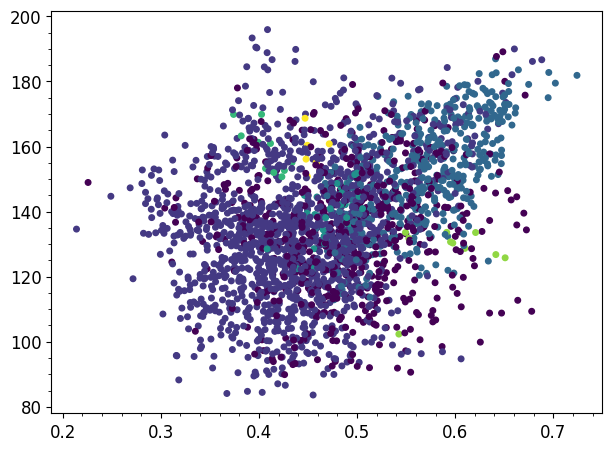

In [38]:
from sklearn.cluster import DBSCAN

cluster = DBSCAN(eps=0.77, min_samples=10).fit(X)
n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
n_noise_ = list(cluster.labels_).count(-1)

print(f"DBSCAN:\n\tnumber of custers = {n_clusters_}\n\toutliers {n_noise_}")
plt.scatter(df["stft_mean"], df["mfcc_std"], c=cluster.labels_)

This is really sensitive to eps value, i try a raster scan

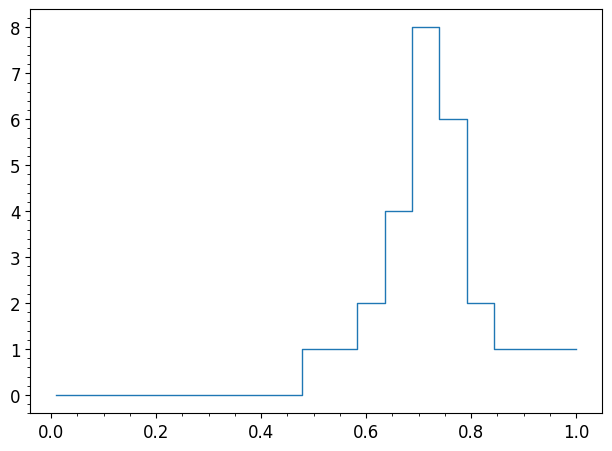

In [30]:
N=20
n = np.zeros(N)
epsilons = np.linspace(0.01, 1.0, N)
for i, eps in enumerate(epsilons):
    cluster = DBSCAN(eps=eps, min_samples=20).fit(X)
    n[i] = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)

plt.step(epsilons, n)

## OPTICS

OPTICS:
	number of custers = 4
	outliers 2349


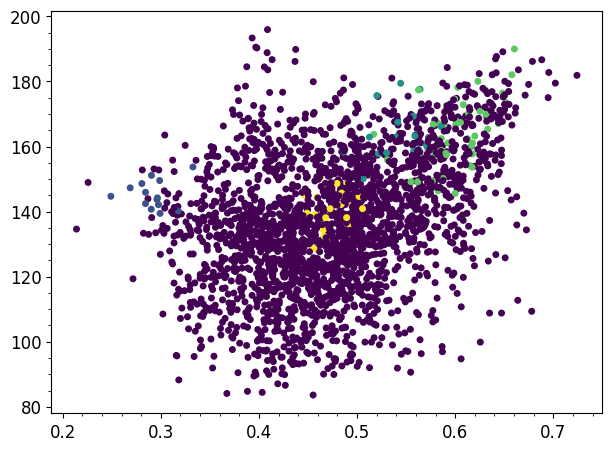

In [42]:
from sklearn.cluster import OPTICS

cluster = OPTICS(eps=0.95, min_samples=10).fit(X)
n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
n_noise_ = list(cluster.labels_).count(-1)

print(f"OPTICS:\n\tnumber of custers = {n_clusters_}\n\toutliers {n_noise_}")
plt.scatter(df["stft_mean"], df["mfcc_std"], c=cluster.labels_)

### Representing the dataset 

This representations are unclear so i use NLDR

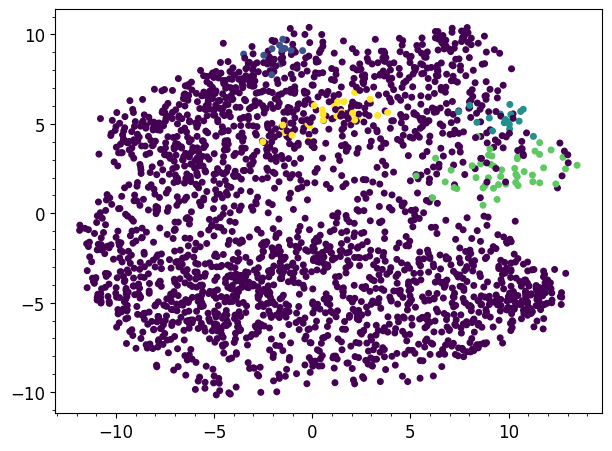

In [45]:
plt.scatter(S_isomap[:,0], S_isomap[:,1], c=cluster.labels_)